# FedFromScratch
## A local implementation of the Federated Learning algorithm (FedAvg) in plain torch


## Introduction

Federated Learning is a distributed machine learning approach that allows training a global model across multiple devices or servers holding local data samples, without exchanging them. The idea is to train a global model by averaging the local models of each device. This way, the data remains on the device, and only the model is shared. This approach is particularly useful when the data is sensitive and cannot be shared, or when the data is too large to be centralized.

More formally, the Federated Learning algorithm can be described as follows:

1. Initialize the global model parameters $\theta$.
2. For each round $r$ in $1, \ldots, R$:
    1. For each `client` $k$ in $1, \ldots, K$:
        1. Send the global model parameters $\theta$ to device $k$.
        2. Train the local models $\theta_k$ using the local data $D_k$ (possibly non iid): $\theta_k \leftarrow \eta_k\nabla_\theta\mathcal{L}(\mathbf{y}, \mathbf{l})$.
        3. Send the local model parameters $\theta_k$ to the server.
    2. Update the global model parameters $\theta \leftarrow \theta = \frac{1}{K} \sum_{k=1}^K \theta_k$
3. Return the global model parameters $\theta$.

In this notebook, we will implement the Federated Learning algorithm in plain torch, using the MNIST dataset. We will use a simple CNN model, and we will train it emulating clients behavior by running each client on a separate process through Joblib. Implementation details and code are proided in the "models.py" file.

Note that we are making simplyfiying assumptions in this implementation, such as the fact that all clients are trained together and they have the same number of samples. In practice, the data is often non-iid, and the clients have different number of samples, or are not available together to train. For this project purposes, we will keep the implementation simple and focus on the core idea of Federated Learning.

## Basic setup and "monolithic" training of the model

In the following cell, we will define the basic setup for the training of the model. We will define the model, the loss function, the optimizer, and the data loaders. We will train the model on the whole dataset to have a baseline to compare the Federated Learning approach.

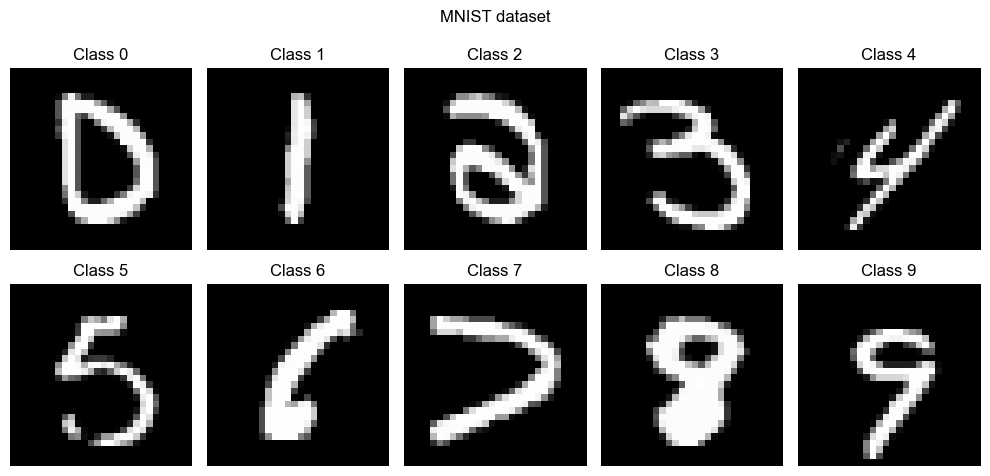

In [1]:
# set autoreload
%load_ext autoreload
%autoreload 2

from models import ConvNet, FederatedServer, ConvNetTrainer, init_clients
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import torch
from utils import plot_mnist, get_mnist_dataloader

# firstly, we create the dataloader for the MNIST dataset
train, val, test = get_mnist_dataloader(64)
plot_mnist(train, 10, 5)

# set grid
sns.set_style('whitegrid')

In [2]:
trainer = ConvNetTrainer(
    ConvNet(), 
    train,          # training set
    val,            # using validation set
    device='mps',   # training using Apple's Metal Performance Shaders, you can also use 'cuda' or 'cpu'
    weight_decay=1e-5,
    lr=0.01
)   

# training the model on the whole training sety (50000 samples), for 10 epochs.
# Optimizer is Adam, with a learning rate of 0.001 and a weight decay of 0.0001
# since this is a very simple task, we can safely ignore a proper model selection procedure.
trainer.train(16)
loss, accuracy = trainer.test(test)

print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Using SGD
Model created and moved to mps
Total number of trainable parameters: 25034


100%|████████████████████████████████████████████████████████| 16/16 [01:36<00:00,  6.02s/it, Loss: 0.049, VL: 0.067, VA: 97.94]


Test loss: 0.0456, accuracy: 0.9847


### We now have a solid baseline model that we will use to compare the performance of the Federated Learning approach.
Without model selelction and further tuning, we reached a CE loss of $0.0456$ and an accuracy of $98.47%$ on the blind test set.

Let's now test the Federated Learning approach. We will first test it on 10 clients, although the number of clients can be easily increased by changing the `n_clients` parameter.

We will train the same model architecture on each client, and according to the algorithm, we will average the weights of the models at the end of each round.  

Each client will draw a subset of 512 data points from the training set, and we will train the model for 5 epochs on each client. We will run 64 rounds of training (64 global updates), with 10 jobs running in parallel (my machine has 10 cores...): in this case, we are assuming that the data is IID across the clients; we will further release this assumption. These parameers reflect those of the original FedAvg paper.

> Note: with this simple setup, we will not implement any advanced techniques to improve the performance of the model, such as learning rate scheduling, early stopping, or data augmentation. The goal is to provide a simple implementation of the Federated Learning algorithm in plain torch. 

> Note: in the spirit of FedAvg, the server is not aware of the data distribution on the clients.

In [3]:
model5e10c  = ConvNet()
server5e10c = FederatedServer(model=model5e10c, test_loader=val)

# we first create 10 clients
clients = init_clients(
    num_clients=10, 
    local_epochs=5, 
    lr=1e-2, 
    train_dataset=train, 
    n_samples=512, 
    device='mps', 
    weight_decay=1e-6, 
    sample_method='iid'
)

loss_5, acc_5 = server5e10c.start_train(clients, n_rounds=128, n_jobs=10)

# save history
# save history
with open('../histories/history_5e10c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_5, 'accuracy': acc_5}, f)

> Client 0 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 1 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 2 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 3 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 4 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 5 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 6 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 7 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 8 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 9 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06


100%|████████████████| 128/128 [04:54<00:00,  2.30s/it, Loss: 0.076, Acc: 97.81]


In [4]:
# test the model on the test set
server5e10c.test_loader = test
loss, accuracy = server5e10c.test()

print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Test loss: 0.0566, accuracy: 0.9819


AttributeError: 'list' object has no attribute 'cpu'

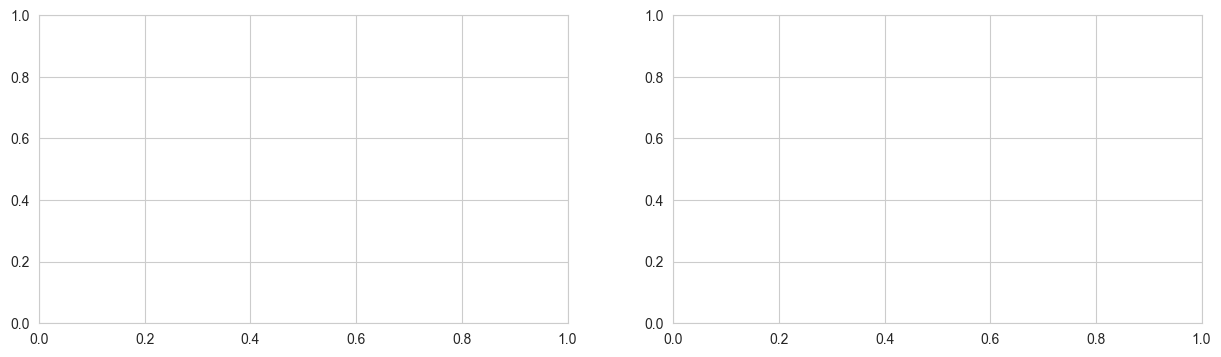

In [6]:
# plot history with seaborn

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss_5)
axs[0].set_title('Cross-entropy loss')
axs[1].plot(acc_5)
axs[1].set_title('Accuracy on validation set')

# set suptitle
fig.suptitle('5 epochs, 10 clients, 64 rounds, 512 iid samples per client')
fig.tight_layout()
plt.show()

### It works! The model trained with Federated Learning reached a CE loss of $0.0688$ and an accuracy of $97.70\%$ on the blind test set.
(I think that there is still some margin for improvement, but the results are already quite good!)


## Testing fedavg on MNIST dataset with different numbers of epochs per client

In [ ]:
model5e  = ConvNet()
server5e = FederatedServer(model=model5e, test_loader=val)

clients = init_clients(
   num_clients=5,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=256,
   device='mps',
   weight_decay=1e-8,
   sample_method='iid'
)

loss_5e, acc_5e = server5e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open('../histories/history_5e5c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_5e, 'accuracy': acc_5e}, f)


model10e  = ConvNet()
server10e = FederatedServer(model=model10e, test_loader=val)

clients = init_clients(
   num_clients=10,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=256,
   device='mps',
   weight_decay=1e-8
)

loss_10e, acc_10e = server10e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open('../histories/history_5e10c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_10e, 'accuracy': acc_10e}, f)

model20e  = ConvNet()
server20e = FederatedServer(model=model20e, test_loader=val)
clients = init_clients(
    num_clients=20,
    local_epochs=5,
    lr=1e-2,
    train_dataset=train,
    n_samples=256,
    device='mps',
    weight_decay=1e-8
)

loss_20e, acc_20e = server20e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open('../histories/history_5e20c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_20e, 'accuracy': acc_20e}, f)

In [14]:
# load histories and convert them to numpy arrays (i made the notebook in several days, so i saved the histories)
with open('../histories/history_5e5c.pkl', 'rb') as f:
    history_5e5c = pickle.load(f)
    loss_5e5c = np.array(history_5e5c['loss'])
    acc_5e5c = np.array(history_5e5c['accuracy'])

with open('../histories/history_5e10c.pkl', 'rb') as f:
    history_5e10c = pickle.load(f)
    loss_5e10c = np.array(history_5e10c['loss'])
    acc_5e10c = np.array(history_5e10c['accuracy'])

with open('../histories/history_5e20c.pkl', 'rb') as f:
    history_5e20c = pickle.load(f)
    loss_5e20c = np.array(history_5e20c['loss'])
    acc_5e20c = np.array(history_5e20c['accuracy'])


In [8]:
# test all models
server5e.test_loader = test
server10e.test_loader = test
server20e.test_loader = test

loss_5e, acc_5e = server5e.test()
loss_10e, acc_10e = server10e.test()
loss_20e, acc_20e = server20e.test()

print(f'5 clients, 5 epochs, 256 samples iid: {acc_5e:.2%}')
print(f'10 clients, 5 epochs, 256 samples iid: {acc_10e:.2%}')
print(f'20 clients, 5 epochs, 256 samples iid: {acc_20e:.2%}')

5 clients, 5 epochs, 256 samples iid: 96.20%
10 clients, 5 epochs, 256 samples iid: 96.04%
20 clients, 5 epochs, 256 samples iid: 96.31%


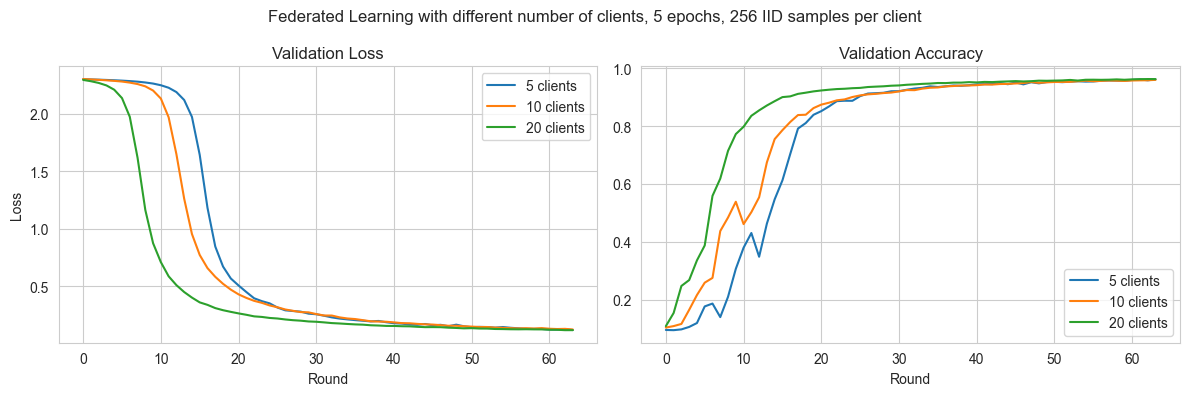

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# set grid
sns.set_style('whitegrid')

# plot the losses and accuracies
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(loss_5e5c, label='5 clients')
axs[0].plot(loss_5e10c, label='10 clients')
axs[0].plot(loss_5e20c, label='20 clients')
axs[0].set_title('Validation Loss')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(acc_5e5c, label='5 clients')
axs[1].plot(acc_5e10c, label='10 clients')
axs[1].plot(acc_5e20c, label='20 clients')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Round')
axs[1].legend()

# set super title
plt.suptitle('Federated Learning with different number of clients, 5 epochs, 256 IID samples per client')
# add some space between the plots
plt.tight_layout()

plt.show()

### Brief comment on the results of this experiment

This results show how all configurations were able to reach satisfying performances and, as I was expecting, the higher the number of the clients, the higher the faster the convergence. However, all models will eventually converge to a stable point. The results are quite good and impressing, considering the low number of data points sampled by each client and the simplicity of the tested CNN used.
We will now proceed to assess performance of federated learning on a more "realistic" scenario, with many clients and small data samples for client.

### Now, let's test federated learning with many clients, each one sampling very few data points from the training set. Again, the distribution is iid across the clients.
This expetiment aims to simulate a more realistic scenario where the data samples are few and distributed across many clients. We will use 128 clients, each one drawing 32 data points from the training set. We will train the model for 5 epochs on each client, and we will run 64 rounds of training with 16 jobs running in parallel.

In [ ]:
model5e128c  = ConvNet()
server = FederatedServer(model=model5e128c, test_loader=val)

clients = init_clients(
   num_clients=128,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=32,
   device='mps',
   weight_decay=1e-10,
   sample_method='iid'
)

loss5e128c, acc5e128c = server.start_train(clients, n_rounds=128, n_jobs=10)

# save history
with open('history_5e128c.pkl', 'wb') as f:
    pickle.dump({'loss': loss5e128c, 'accuracy': acc5e128c}, f)

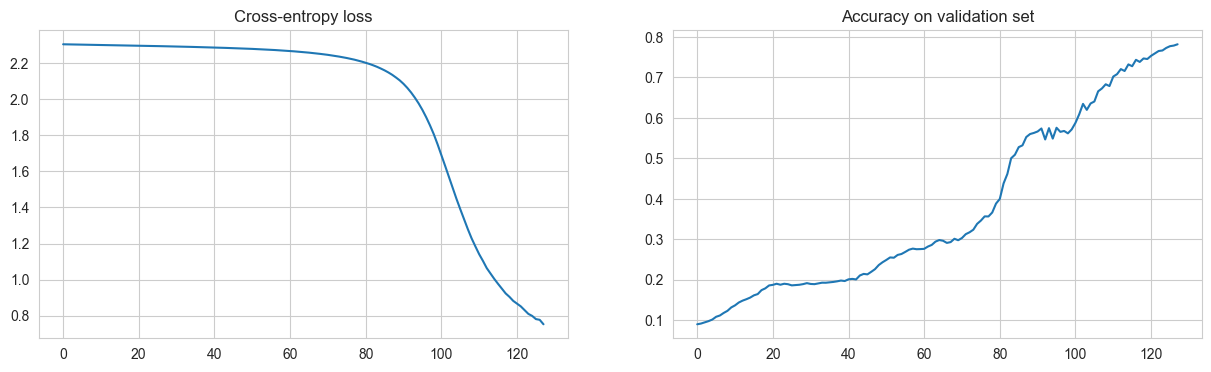

In [29]:
with open('../histories/history_5e128c.pkl', 'rb') as f:
    history = pickle.load(f)

loss5e128c = history['loss']
acc_5e128c = history['accuracy']

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss5e128c)
axs[0].set_title('Cross-entropy loss')
 
axs[1].plot(acc_5e128c)
axs[1].set_title('Accuracy on validation set')
plt.show()

### Convergence is really slow.
However, after many rounds, model suddently starts to improve and generalize. This suggests exactly what we would expect in a federated learning scenario: the model is able to learn from the local data of each client, and it is able to generalize to the global data distribution. This is a very interesting result, and it shows the potential of Federated Learning in real-world scenarios. Moreover, in a more realistic setting, where clients only have to fine-tune the model (e.g. few-shot learning), it is my opinion that the convergence would be much faster.

We will now proceed to test the federated learning performance on a more realistic scenario, where the data is non-iid across the clients.

## The pathological case: non-iid data distribution across the clients

In a federated learning application (e.g. keyboard text prediction) we must release the assumption that the data is iid across the clients: we can have sampling bias and different data distributions across the clients, e.g. different languages, different writing styles, etc. We will try to check how the model performs in this case.

Experimental setup:
In order to simulate what the authors of the original FedAvg refer to "pathological non iid case" we will split the MNIST dataset in 10 shards, each one containing the images of two digits. This is a very simple (though extreme) way to create a non-iid data distribution across the clients. We will then train the model on 10 clients, each one holding a different sample of its assigned digits.

Full code of this split is straightforward and it is reported in the following snippet for completeness:

```python

def _sample_data_noniid(self):
    # select a a key from the mnist dataset randomly
    subset_a = [s for s in self.train_loader.dataset if s[1] == self.k % 10]
    subset_b = [s for s in self.train_loader.dataset if s[1] == (self.k + 1) % 10]
    # sample n_samples from the subset
    subset_a = Subset(subset_a, list(RandomSampler(subset_a, num_samples=self.n_samples//2)))
    subset_b = Subset(subset_b, list(RandomSampler(subset_b, num_samples=self.n_samples//2)))

    subset = torch.utils.data.ConcatDataset([subset_a, subset_b])
```

I expect this setup to be very challenging for the model, since we are again starting from a random weights configuration and averaging models trained on completely different data.

In [ ]:
model_niid  = ConvNet()
server_niid = FederatedServer(model=model_niid, test_loader=val)

clients = init_clients(
   num_clients=16,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=256,
   device='mps',
   weight_decay=1e-10,
   sample_method='niid'
)

loss_niid, acc_niid = server_niid.start_train(clients, n_rounds=64, n_jobs=8)

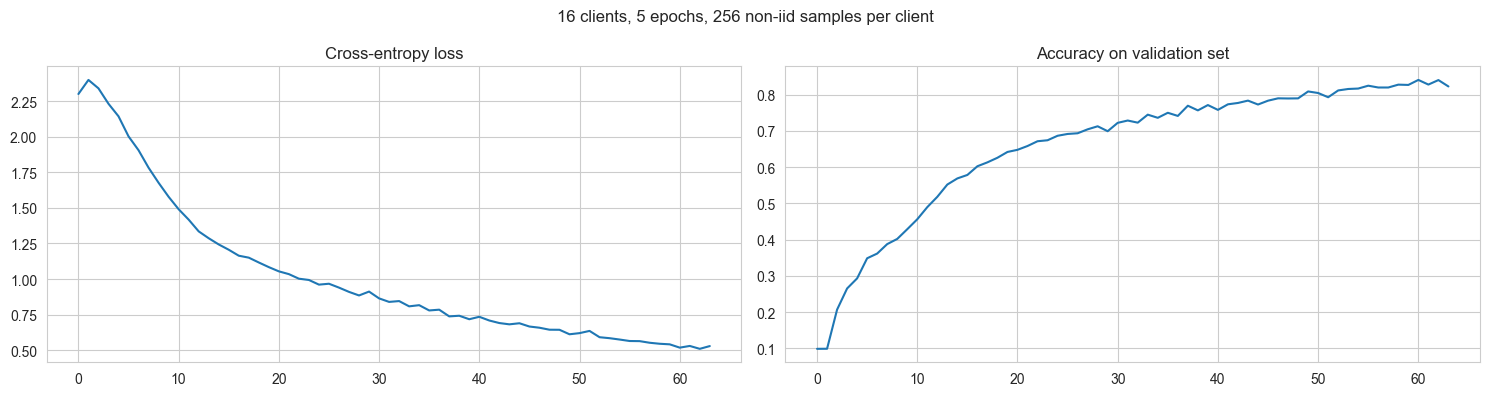

In [9]:
# save history
with open('../histories/history_niid.pkl', 'wb') as f:
    pickle.dump({'loss': loss_niid, 'accuracy': acc_niid}, f)

# plot history with seaborn
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss_niid)
axs[0].set_title('Cross-entropy loss')
axs[1].plot(acc_niid)
axs[1].set_title('Accuracy on validation set')

# set suptitle
fig.suptitle('16 clients, 5 epochs, 256 non-iid samples per client')
fig.tight_layout()
plt.show()

## Results of the non-iid data distribution experiment

This convergence, with this particular configuration, is painfully slow: in fact, I was expecting this behaviour given the fact that each client is trained on a completely different data distribution. Each client is forced by its local SGD optimizer towards a distribution, and averaging weights will potentially distrupt local's optimization steps.

Nonetheles, the global model is able to learn from the local data of each client and to generalize to the global data distribution. Looking at the learning curves, I was expecting a slow convergence in the first epochs, and a sudden drop in the cross-entropy loss at a given epoch, when the global model, which started to generalize across all the dataset, was sent again to the clients. However, this is not what happened, and the convergence rate kept being the same across all the 64 global updates.


This is a very interesting result, and it shows the potential of Federated Learning in real-world scenarios. Again in a more realistic setting, where clients only have to fine-tune the model (e.g. few-shot learning), this would be much faster. I also thik that having an huge number of clients and rounds to train the global model will help the algorithm to converge faster. Unfortunately, I was not able to test this hypothesis due to the computational resources required.

## Another test: try fashion-mnist dataset

_"If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."_
In this perspective, let's try it on the fashion-mnist dataset, which is a bit more challenging than the original MNIST dataset.


### Again, let's first establish a baseline on the fashion-mnist dataset, with a simple cnn.

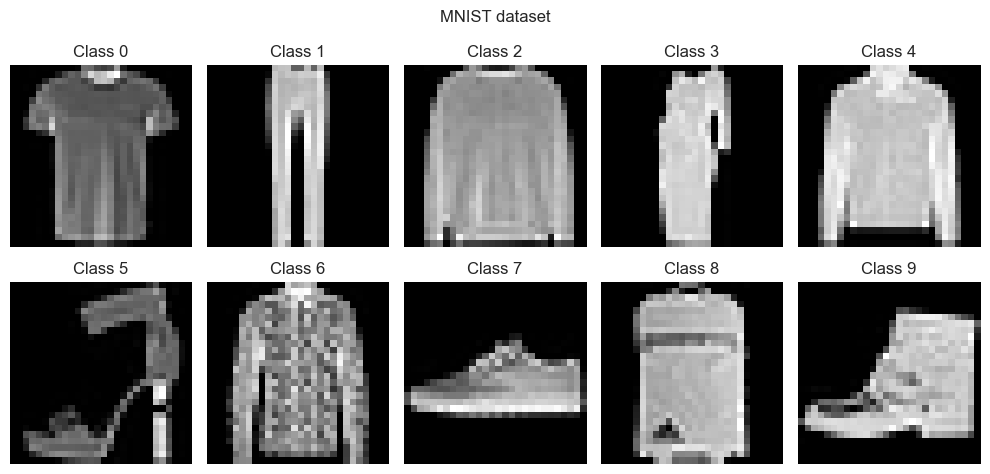

In [17]:
# import the fashion mnist dataset
from models import MNISTConvNet, FederatedServer, MNISTConvNetTrainer, get_mnist_dataloader, init_clients, get_fashion_mnist_dataloader
from utils import plot_mnist
from matplotlib import pyplot as plt
import seaborn as sns

train, val, test = get_fashion_mnist_dataloader(64)

plot_mnist(train, 10, 5)

In [18]:
# train the model on the whole training set
trainer = MNISTConvNetTrainer(
    MNISTConvNet(), 
    train, 
    val, 
    device='mps', 
    weight_decay=1e-5,
    lr=0.01
)

trainer.train(32)
loss, accuracy = trainer.test(test)

print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Model created and moved to mps


  3%|█▍                                          | 1/32 [00:06<03:07,  6.05s/it]

Epoch 1, Loss: 1.4595076908235964, Accuracy: 0.45458, Val Loss: 1.072212815284729, Val Acc: 0.613


  6%|██▊                                         | 2/32 [00:12<03:01,  6.04s/it]

Epoch 2, Loss: 0.777333305848529, Accuracy: 0.70564, Val Loss: 0.794249415397644, Val Acc: 0.6892


  9%|████▏                                       | 3/32 [00:18<02:55,  6.05s/it]

Epoch 3, Loss: 0.6569860619504738, Accuracy: 0.75676, Val Loss: 0.6932663917541504, Val Acc: 0.7367


 12%|█████▌                                      | 4/32 [00:24<02:48,  6.02s/it]

Epoch 4, Loss: 0.5844119007096571, Accuracy: 0.78554, Val Loss: 0.6617841124534607, Val Acc: 0.7391


 16%|██████▉                                     | 5/32 [00:30<02:42,  6.04s/it]

Epoch 5, Loss: 0.5368633718822923, Accuracy: 0.80384, Val Loss: 0.4860951602458954, Val Acc: 0.8243


 19%|████████▎                                   | 6/32 [00:36<02:36,  6.01s/it]

Epoch 6, Loss: 0.5023957149070852, Accuracy: 0.81724, Val Loss: 0.5227453708648682, Val Acc: 0.8069


 22%|█████████▋                                  | 7/32 [00:42<02:30,  6.02s/it]

Epoch 7, Loss: 0.4740946230947819, Accuracy: 0.82706, Val Loss: 0.4185919761657715, Val Acc: 0.8472


 25%|███████████                                 | 8/32 [00:48<02:24,  6.01s/it]

Epoch 8, Loss: 0.45167367960638405, Accuracy: 0.83546, Val Loss: 0.45836392045021057, Val Acc: 0.8318


 28%|████████████▍                               | 9/32 [00:54<02:18,  6.01s/it]

Epoch 9, Loss: 0.4344084200918522, Accuracy: 0.84038, Val Loss: 0.3867294192314148, Val Acc: 0.8581


 31%|█████████████▍                             | 10/32 [01:00<02:11,  6.00s/it]

Epoch 10, Loss: 0.41765771314616096, Accuracy: 0.8468, Val Loss: 0.7169125080108643, Val Acc: 0.7236


 34%|██████████████▊                            | 11/32 [01:06<02:06,  6.01s/it]

Epoch 11, Loss: 0.404151509046707, Accuracy: 0.85132, Val Loss: 0.584282398223877, Val Acc: 0.7794


 38%|████████████████▏                          | 12/32 [01:12<02:00,  6.00s/it]

Epoch 12, Loss: 0.39219223121014396, Accuracy: 0.85748, Val Loss: 0.42846694588661194, Val Acc: 0.8296


 41%|█████████████████▍                         | 13/32 [01:18<01:54,  6.01s/it]

Epoch 13, Loss: 0.381011437386503, Accuracy: 0.85988, Val Loss: 0.3714675307273865, Val Acc: 0.8652


 44%|██████████████████▊                        | 14/32 [01:24<01:48,  6.01s/it]

Epoch 14, Loss: 0.37093898466290415, Accuracy: 0.86464, Val Loss: 0.3597255051136017, Val Acc: 0.8663


 47%|████████████████████▏                      | 15/32 [01:30<01:42,  6.01s/it]

Epoch 15, Loss: 0.3621388732853448, Accuracy: 0.8683, Val Loss: 0.3414537310600281, Val Acc: 0.8755


 50%|█████████████████████▌                     | 16/32 [01:36<01:36,  6.02s/it]

Epoch 16, Loss: 0.3543368287937111, Accuracy: 0.87006, Val Loss: 0.35271334648132324, Val Acc: 0.8706


 53%|██████████████████████▊                    | 17/32 [01:42<01:33,  6.21s/it]

Epoch 17, Loss: 0.34713734206183794, Accuracy: 0.87352, Val Loss: 0.34357354044914246, Val Acc: 0.8728


 56%|████████████████████████▏                  | 18/32 [01:49<01:29,  6.37s/it]

Epoch 18, Loss: 0.3412989314712222, Accuracy: 0.8764, Val Loss: 0.3121466338634491, Val Acc: 0.8862


 59%|█████████████████████████▌                 | 19/32 [01:56<01:24,  6.47s/it]

Epoch 19, Loss: 0.33433134770949785, Accuracy: 0.87752, Val Loss: 0.3131704032421112, Val Acc: 0.8845


 62%|██████████████████████████▉                | 20/32 [02:03<01:19,  6.59s/it]

Epoch 20, Loss: 0.32925597059985867, Accuracy: 0.88002, Val Loss: 0.32991325855255127, Val Acc: 0.8798


 66%|████████████████████████████▏              | 21/32 [02:10<01:13,  6.68s/it]

Epoch 21, Loss: 0.3238229624393498, Accuracy: 0.8825, Val Loss: 0.31381121277809143, Val Acc: 0.8836


 69%|█████████████████████████████▌             | 22/32 [02:16<01:06,  6.69s/it]

Epoch 22, Loss: 0.31879489684996704, Accuracy: 0.88406, Val Loss: 0.3300172984600067, Val Acc: 0.878


 72%|██████████████████████████████▉            | 23/32 [02:23<01:00,  6.71s/it]

Epoch 23, Loss: 0.313710958432511, Accuracy: 0.8859, Val Loss: 0.3064110577106476, Val Acc: 0.8881


 75%|████████████████████████████████▎          | 24/32 [02:30<00:53,  6.69s/it]

Epoch 24, Loss: 0.308783551263611, Accuracy: 0.88692, Val Loss: 0.3172703981399536, Val Acc: 0.8785


 78%|█████████████████████████████████▌         | 25/32 [02:36<00:45,  6.56s/it]

Epoch 25, Loss: 0.3036017240599141, Accuracy: 0.88976, Val Loss: 0.299123078584671, Val Acc: 0.8949


 81%|██████████████████████████████████▉        | 26/32 [02:43<00:39,  6.65s/it]

Epoch 26, Loss: 0.3005569777296632, Accuracy: 0.8905, Val Loss: 0.3047299087047577, Val Acc: 0.8899


 84%|████████████████████████████████████▎      | 27/32 [02:50<00:33,  6.71s/it]

Epoch 27, Loss: 0.29494324169309855, Accuracy: 0.89256, Val Loss: 0.2991557717323303, Val Acc: 0.8899


 88%|█████████████████████████████████████▋     | 28/32 [02:57<00:27,  6.75s/it]

Epoch 28, Loss: 0.29200982984603213, Accuracy: 0.89314, Val Loss: 0.315911203622818, Val Acc: 0.8795


 91%|██████████████████████████████████████▉    | 29/32 [03:03<00:20,  6.73s/it]

Epoch 29, Loss: 0.28845158928190656, Accuracy: 0.89246, Val Loss: 0.28399065136909485, Val Acc: 0.8958


 94%|████████████████████████████████████████▎  | 30/32 [03:10<00:13,  6.74s/it]

Epoch 30, Loss: 0.2840795289925145, Accuracy: 0.89648, Val Loss: 0.2955963611602783, Val Acc: 0.8897


 97%|█████████████████████████████████████████▋ | 31/32 [03:17<00:06,  6.75s/it]

Epoch 31, Loss: 0.2813020481268311, Accuracy: 0.8977, Val Loss: 0.28433817625045776, Val Acc: 0.8942


100%|███████████████████████████████████████████| 32/32 [03:23<00:00,  6.36s/it]

Epoch 32, Loss: 0.27972383701892767, Accuracy: 0.89744, Val Loss: 0.27073371410369873, Val Acc: 0.8997


Test loss: 0.3006, accuracy: 0.8905


Our baseline is a simple CNN that reached a CE loss of $0.3006$ and an accuracy of $89.05\%$ on the blind test set. These results are coherent with the benchmarks for my simple CNN model on the fashion-mnist dataset.


### FashionFed

In [19]:
model5e10c  = MNISTConvNet()
server5e10c = FederatedServer(model=model5e10c, test_loader=val)

clients = init_clients(
    num_clients=10, 
    local_epochs=5, 
    lr=1e-2, 
    train_dataset=train, 
    n_samples=512, 
    device='mps', 
    weight_decay=1e-6, 
    sample_method='iid'
)

loss_5, acc_5 = server5e10c.start_train(clients, n_rounds=128, n_jobs=10)

# save history
with open('../histories/history_5e10c_fashion.pkl', 'wb') as f:
    pickle.dump({'loss': loss_5, 'accuracy': acc_5}, f)

# save global model
torch.save(server5e10c.global_model.state_dict(), '../models/model5e10c_fashion.pth')

> Client 0 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 1 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 2 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 3 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 4 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 5 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 6 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 7 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 8 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 9 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 99.40it/s]


Aggregating 10 local states

Round 0, Test Loss: 2.2870771884918213, Test Acc: 0.1828


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7348.11it/s]


Aggregating 10 local states

Round 1, Test Loss: 2.2438673973083496, Test Acc: 0.2235


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9218.25it/s]


Aggregating 10 local states

Round 2, Test Loss: 1.9929081201553345, Test Acc: 0.4018


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9506.58it/s]


Aggregating 10 local states

Round 3, Test Loss: 1.1675938367843628, Test Acc: 0.6027


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9813.53it/s]


Aggregating 10 local states

Round 4, Test Loss: 0.995995283126831, Test Acc: 0.6395


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13815.23it/s]


Aggregating 10 local states

Round 5, Test Loss: 0.9322890639305115, Test Acc: 0.6614


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11278.04it/s]


Aggregating 10 local states

Round 6, Test Loss: 0.8713436126708984, Test Acc: 0.6794


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12118.76it/s]


Aggregating 10 local states

Round 7, Test Loss: 0.8533855676651001, Test Acc: 0.6818


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14685.94it/s]


Aggregating 10 local states

Round 8, Test Loss: 0.814278781414032, Test Acc: 0.7045


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9302.07it/s]


Aggregating 10 local states

Round 9, Test Loss: 0.7901966571807861, Test Acc: 0.7087


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13247.96it/s]


Aggregating 10 local states

Round 10, Test Loss: 0.7731751799583435, Test Acc: 0.7066


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11087.24it/s]


Aggregating 10 local states

Round 11, Test Loss: 0.7459001541137695, Test Acc: 0.7262


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13847.16it/s]


Aggregating 10 local states

Round 12, Test Loss: 0.7281382083892822, Test Acc: 0.7327


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11891.99it/s]


Aggregating 10 local states

Round 13, Test Loss: 0.7099776268005371, Test Acc: 0.7425


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11290.19it/s]


Aggregating 10 local states

Round 14, Test Loss: 0.6983912587165833, Test Acc: 0.7384


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13438.97it/s]


Aggregating 10 local states

Round 15, Test Loss: 0.674028217792511, Test Acc: 0.7496


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7370.07it/s]


Aggregating 10 local states

Round 16, Test Loss: 0.659690260887146, Test Acc: 0.7566


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15471.43it/s]


Aggregating 10 local states

Round 17, Test Loss: 0.6501134037971497, Test Acc: 0.7585


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11818.27it/s]


Aggregating 10 local states

Round 18, Test Loss: 0.6391689777374268, Test Acc: 0.7621


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12256.88it/s]


Aggregating 10 local states

Round 19, Test Loss: 0.6272498369216919, Test Acc: 0.7658


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10557.02it/s]


Aggregating 10 local states

Round 20, Test Loss: 0.6110764145851135, Test Acc: 0.7742


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16076.29it/s]


Aggregating 10 local states

Round 21, Test Loss: 0.5984066724777222, Test Acc: 0.7786


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10392.23it/s]


Aggregating 10 local states

Round 22, Test Loss: 0.5901870131492615, Test Acc: 0.7783


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13017.70it/s]


Aggregating 10 local states

Round 23, Test Loss: 0.5808380246162415, Test Acc: 0.7838


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11990.58it/s]


Aggregating 10 local states

Round 24, Test Loss: 0.5800224542617798, Test Acc: 0.7809


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11915.64it/s]


Aggregating 10 local states

Round 25, Test Loss: 0.5639184713363647, Test Acc: 0.79


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8937.36it/s]


Aggregating 10 local states

Round 26, Test Loss: 0.562640905380249, Test Acc: 0.7862


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14883.97it/s]


Aggregating 10 local states

Round 27, Test Loss: 0.5431695580482483, Test Acc: 0.7993


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12253.30it/s]


Aggregating 10 local states

Round 28, Test Loss: 0.5426734089851379, Test Acc: 0.803


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10821.22it/s]


Aggregating 10 local states

Round 29, Test Loss: 0.5310325026512146, Test Acc: 0.8047


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14089.03it/s]


Aggregating 10 local states

Round 30, Test Loss: 0.5222555994987488, Test Acc: 0.809


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9200.05it/s]


Aggregating 10 local states

Round 31, Test Loss: 0.5286661386489868, Test Acc: 0.8015


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14222.80it/s]


Aggregating 10 local states

Round 32, Test Loss: 0.5130852460861206, Test Acc: 0.8108


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11014.45it/s]


Aggregating 10 local states

Round 33, Test Loss: 0.5116909742355347, Test Acc: 0.8103


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10931.21it/s]


Aggregating 10 local states

Round 34, Test Loss: 0.505280077457428, Test Acc: 0.8185


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10121.39it/s]


Aggregating 10 local states

Round 35, Test Loss: 0.5053488612174988, Test Acc: 0.8138


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13160.67it/s]


Aggregating 10 local states

Round 36, Test Loss: 0.49695777893066406, Test Acc: 0.8187


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9804.36it/s]


Aggregating 10 local states

Round 37, Test Loss: 0.49294233322143555, Test Acc: 0.8204


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11497.54it/s]


Aggregating 10 local states

Round 38, Test Loss: 0.48676568269729614, Test Acc: 0.8215


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13070.44it/s]


Aggregating 10 local states

Round 39, Test Loss: 0.4800199270248413, Test Acc: 0.8286


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12031.85it/s]


Aggregating 10 local states

Round 40, Test Loss: 0.47701239585876465, Test Acc: 0.8247


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17608.33it/s]


Aggregating 10 local states

Round 41, Test Loss: 0.4762059450149536, Test Acc: 0.8276


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13626.72it/s]


Aggregating 10 local states

Round 42, Test Loss: 0.47017887234687805, Test Acc: 0.8309


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14290.64it/s]


Aggregating 10 local states

Round 43, Test Loss: 0.46655943989753723, Test Acc: 0.8331


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11795.01it/s]


Aggregating 10 local states

Round 44, Test Loss: 0.4629666805267334, Test Acc: 0.8292


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1058.87it/s]


Aggregating 10 local states

Round 45, Test Loss: 0.4603830873966217, Test Acc: 0.832


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12453.40it/s]


Aggregating 10 local states

Round 46, Test Loss: 0.46238023042678833, Test Acc: 0.8314


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17600.94it/s]


Aggregating 10 local states

Round 47, Test Loss: 0.4520682096481323, Test Acc: 0.837


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13005.59it/s]


Aggregating 10 local states

Round 48, Test Loss: 0.45200756192207336, Test Acc: 0.8381


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17697.49it/s]


Aggregating 10 local states

Round 49, Test Loss: 0.44992443919181824, Test Acc: 0.8352


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10549.05it/s]


Aggregating 10 local states

Round 50, Test Loss: 0.4487239122390747, Test Acc: 0.8358


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11696.33it/s]


Aggregating 10 local states

Round 51, Test Loss: 0.4417397975921631, Test Acc: 0.8402


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1080.62it/s]


Aggregating 10 local states

Round 52, Test Loss: 0.4383346736431122, Test Acc: 0.8402


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11428.62it/s]


Aggregating 10 local states

Round 53, Test Loss: 0.43632468581199646, Test Acc: 0.8417


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16206.74it/s]


Aggregating 10 local states

Round 54, Test Loss: 0.43449854850769043, Test Acc: 0.8423


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12656.32it/s]


Aggregating 10 local states

Round 55, Test Loss: 0.4293193519115448, Test Acc: 0.842


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11919.02it/s]


Aggregating 10 local states

Round 56, Test Loss: 0.42825278639793396, Test Acc: 0.846


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10846.40it/s]


Aggregating 10 local states

Round 57, Test Loss: 0.4287729561328888, Test Acc: 0.8437


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10480.52it/s]


Aggregating 10 local states

Round 58, Test Loss: 0.42888712882995605, Test Acc: 0.8463


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11063.85it/s]


Aggregating 10 local states

Round 59, Test Loss: 0.42013636231422424, Test Acc: 0.8484


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12993.51it/s]


Aggregating 10 local states

Round 60, Test Loss: 0.42381271719932556, Test Acc: 0.8471


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8912.67it/s]


Aggregating 10 local states

Round 61, Test Loss: 0.4185853600502014, Test Acc: 0.8495


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10267.57it/s]


Aggregating 10 local states

Round 62, Test Loss: 0.41883519291877747, Test Acc: 0.8482


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10525.23it/s]


Aggregating 10 local states

Round 63, Test Loss: 0.4187343716621399, Test Acc: 0.8485


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11096.04it/s]


Aggregating 10 local states

Round 64, Test Loss: 0.4156356751918793, Test Acc: 0.8484


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12937.40it/s]


Aggregating 10 local states

Round 65, Test Loss: 0.4117244482040405, Test Acc: 0.8508


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12300.01it/s]


Aggregating 10 local states

Round 66, Test Loss: 0.41142240166664124, Test Acc: 0.8513


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15899.56it/s]


Aggregating 10 local states

Round 67, Test Loss: 0.4039575457572937, Test Acc: 0.8547


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14644.92it/s]


Aggregating 10 local states

Round 68, Test Loss: 0.4135940968990326, Test Acc: 0.851


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13054.17it/s]


Aggregating 10 local states

Round 69, Test Loss: 0.40563902258872986, Test Acc: 0.8525


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13870.05it/s]


Aggregating 10 local states

Round 70, Test Loss: 0.40889984369277954, Test Acc: 0.8523


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11834.94it/s]


Aggregating 10 local states

Round 71, Test Loss: 0.39962437748908997, Test Acc: 0.8546


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14009.03it/s]


Aggregating 10 local states

Round 72, Test Loss: 0.39821183681488037, Test Acc: 0.8577


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9606.74it/s]


Aggregating 10 local states

Round 73, Test Loss: 0.39985597133636475, Test Acc: 0.8535


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12423.89it/s]


Aggregating 10 local states

Round 74, Test Loss: 0.39579901099205017, Test Acc: 0.8588


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17985.87it/s]


Aggregating 10 local states

Round 75, Test Loss: 0.39588120579719543, Test Acc: 0.8589


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12675.44it/s]


Aggregating 10 local states

Round 76, Test Loss: 0.39444419741630554, Test Acc: 0.8575


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17210.93it/s]


Aggregating 10 local states

Round 77, Test Loss: 0.396155446767807, Test Acc: 0.8567


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12706.16it/s]


Aggregating 10 local states

Round 78, Test Loss: 0.3948659896850586, Test Acc: 0.8564


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11299.31it/s]


Aggregating 10 local states

Round 79, Test Loss: 0.3922164738178253, Test Acc: 0.8611


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9353.93it/s]


Aggregating 10 local states

Round 80, Test Loss: 0.39162489771842957, Test Acc: 0.8592


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15768.06it/s]


Aggregating 10 local states

Round 81, Test Loss: 0.39034581184387207, Test Acc: 0.8607


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9131.95it/s]


Aggregating 10 local states

Round 82, Test Loss: 0.3861396610736847, Test Acc: 0.8628


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14079.57it/s]


Aggregating 10 local states

Round 83, Test Loss: 0.3850983679294586, Test Acc: 0.8619


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12656.32it/s]


Aggregating 10 local states

Round 84, Test Loss: 0.38175851106643677, Test Acc: 0.864


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12136.30it/s]


Aggregating 10 local states

Round 85, Test Loss: 0.38439467549324036, Test Acc: 0.862


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10787.82it/s]


Aggregating 10 local states

Round 86, Test Loss: 0.3786541819572449, Test Acc: 0.8641


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14878.69it/s]


Aggregating 10 local states

Round 87, Test Loss: 0.38154834508895874, Test Acc: 0.8645


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9998.34it/s]


Aggregating 10 local states

Round 88, Test Loss: 0.3812123239040375, Test Acc: 0.8629


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12546.53it/s]


Aggregating 10 local states

Round 89, Test Loss: 0.3773367404937744, Test Acc: 0.8656


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13530.01it/s]


Aggregating 10 local states

Round 90, Test Loss: 0.37934064865112305, Test Acc: 0.8618


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12108.27it/s]


Aggregating 10 local states

Round 91, Test Loss: 0.3792194724082947, Test Acc: 0.864


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12358.00it/s]


Aggregating 10 local states

Round 92, Test Loss: 0.3750295639038086, Test Acc: 0.8662


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11122.52it/s]


Aggregating 10 local states

Round 93, Test Loss: 0.3761534094810486, Test Acc: 0.8658


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12376.23it/s]


Aggregating 10 local states

Round 94, Test Loss: 0.37482771277427673, Test Acc: 0.8647


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12740.90it/s]


Aggregating 10 local states

Round 95, Test Loss: 0.37312746047973633, Test Acc: 0.8661


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14533.28it/s]


Aggregating 10 local states

Round 96, Test Loss: 0.3743845224380493, Test Acc: 0.8657


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11599.29it/s]


Aggregating 10 local states

Round 97, Test Loss: 0.3720273971557617, Test Acc: 0.8655


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14768.68it/s]


Aggregating 10 local states

Round 98, Test Loss: 0.3714357912540436, Test Acc: 0.8659


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11275.01it/s]


Aggregating 10 local states

Round 99, Test Loss: 0.37172916531562805, Test Acc: 0.8637


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11332.89it/s]


Aggregating 10 local states

Round 100, Test Loss: 0.36835289001464844, Test Acc: 0.8672


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14573.68it/s]


Aggregating 10 local states

Round 101, Test Loss: 0.3700698912143707, Test Acc: 0.8653


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13662.23it/s]


Aggregating 10 local states

Round 102, Test Loss: 0.3670038878917694, Test Acc: 0.8672


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12771.94it/s]


Aggregating 10 local states

Round 103, Test Loss: 0.36686602234840393, Test Acc: 0.8675


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1090.99it/s]


Aggregating 10 local states

Round 104, Test Loss: 0.36569294333457947, Test Acc: 0.8654


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 18550.66it/s]


Aggregating 10 local states

Round 105, Test Loss: 0.3624957501888275, Test Acc: 0.8686


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12035.31it/s]


Aggregating 10 local states

Round 106, Test Loss: 0.3634208142757416, Test Acc: 0.8699


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17210.93it/s]


Aggregating 10 local states

Round 107, Test Loss: 0.3654647171497345, Test Acc: 0.8702


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10691.57it/s]


Aggregating 10 local states

Round 108, Test Loss: 0.3609679043292999, Test Acc: 0.868


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10000.72it/s]


Aggregating 10 local states

Round 109, Test Loss: 0.36014971137046814, Test Acc: 0.8696


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11602.50it/s]


Aggregating 10 local states

Round 110, Test Loss: 0.3569009602069855, Test Acc: 0.8702


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13103.11it/s]


Aggregating 10 local states

Round 111, Test Loss: 0.3604068458080292, Test Acc: 0.8699


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12076.89it/s]


Aggregating 10 local states

Round 112, Test Loss: 0.35738080739974976, Test Acc: 0.8706


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12497.93it/s]


Aggregating 10 local states

Round 113, Test Loss: 0.3584330976009369, Test Acc: 0.8689


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11441.09it/s]


Aggregating 10 local states

Round 114, Test Loss: 0.3561248183250427, Test Acc: 0.8679


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11990.58it/s]


Aggregating 10 local states

Round 115, Test Loss: 0.35752978920936584, Test Acc: 0.8686


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10572.99it/s]


Aggregating 10 local states

Round 116, Test Loss: 0.35421591997146606, Test Acc: 0.8709


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11510.16it/s]


Aggregating 10 local states

Round 117, Test Loss: 0.3602927625179291, Test Acc: 0.8682


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13888.42it/s]


Aggregating 10 local states

Round 118, Test Loss: 0.3546616733074188, Test Acc: 0.8685


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13874.64it/s]


Aggregating 10 local states

Round 119, Test Loss: 0.3538413643836975, Test Acc: 0.8714


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11987.15it/s]


Aggregating 10 local states

Round 120, Test Loss: 0.35463154315948486, Test Acc: 0.8688


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11848.32it/s]


Aggregating 10 local states

Round 121, Test Loss: 0.3540169894695282, Test Acc: 0.8705


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9700.06it/s]


Aggregating 10 local states

Round 122, Test Loss: 0.3492162823677063, Test Acc: 0.8704


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10111.63it/s]


Aggregating 10 local states

Round 123, Test Loss: 0.3492451310157776, Test Acc: 0.8725


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7076.61it/s]


Aggregating 10 local states

Round 124, Test Loss: 0.34729528427124023, Test Acc: 0.8749


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10048.64it/s]


Aggregating 10 local states

Round 125, Test Loss: 0.3471437394618988, Test Acc: 0.8722


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13210.41it/s]


Aggregating 10 local states

Round 126, Test Loss: 0.347841739654541, Test Acc: 0.8722


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9218.25it/s]


Aggregating 10 local states

Round 127, Test Loss: 0.34757566452026367, Test Acc: 0.8728


In [20]:
# test the model on the test set
with open('../histories/history_5e10c_fashion.pkl', 'rb') as f:
    history = pickle.load(f)
    loss_5e10c = np.array(history['loss'])
    acc_5e10c = np.array(history['accuracy'])

server5e10c.test_loader = test
loss, accuracy = server5e10c.test()

print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Test loss: 0.3850, accuracy: 0.8633


Text(0.5, 0.98, '5 epochs, 10 clients, 64 rounds, 512 iid samples per client')

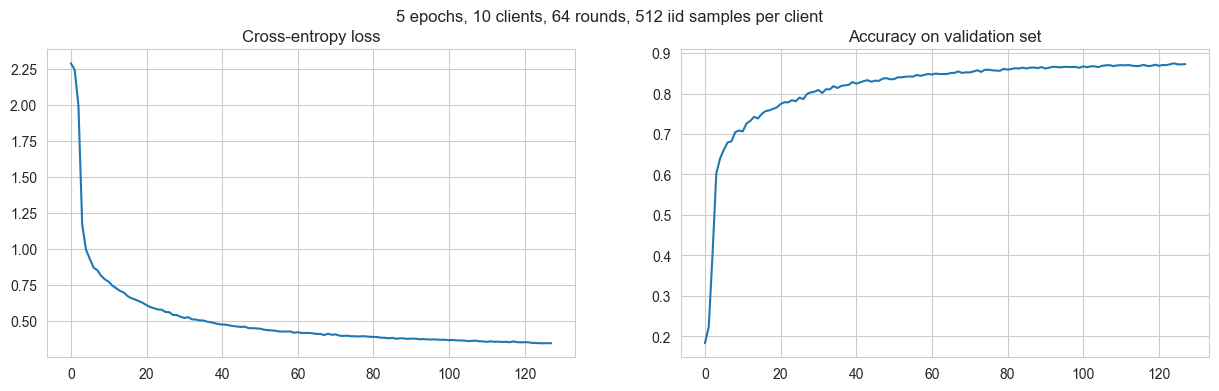

In [21]:
# plot history with seaborn
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss_5e10c)
axs[0].set_title('Cross-entropy loss')
axs[1].plot(acc_5e10c)
axs[1].set_title('Accuracy on validation set')

# set suptitle
fig.suptitle('5 epochs, 10 clients, 64 rounds, 512 iid samples per client')

### Again, good results.
Model is able to learn quickly also from more complex datasets, achieving a total test accuracy of $86.33\%$ and a CE loss of $0.3850$, reaching a good performance in a reasonable amount of time.

## Federated Fine-Tuning of EfficientNet on CIFAR10

As our final task, we will test the Federated Learning algorithm on a more complex dataset, CIFAR10. We will use a pre-trained EfficientNet B0 model, and we will fine-tune it on the CIFAR10 dataset using the Federated Learning algorithm. Standard Finetuning with AdamW lead to 80% accuracy on the test set. Results of this finetuning can be found in "ened.ipynb" notebook.

In [1]:
from utils import get_cifar10_dataloader, plot_mnist
from models import FederatedServer, init_clients
# import efficientnet from torchvision models

import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

train, val, test = get_cifar10_dataloader(64)
#resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in effnet.parameters():
    param.requires_grad = False
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, 102)

Files already downloaded and verified


In [2]:
#plot_mnist(train, 10, 5)

In [3]:
# initialize clients
clients = init_clients(
    num_clients=10, 
    local_epochs=1, 
    lr=1e-3, 
    train_dataset=train, 
    n_samples=512, 
    device='mps', 
    weight_decay=1e-6, 
    sample_method='iid',
    model=effnet
)

# create server
server = FederatedServer(model=effnet, test_loader=val)
loss, acc = server.start_train(clients, n_rounds=64, n_jobs=2)

> Client 0 created, lr: 0.001, epochs: 1, samples: 512, device: mps, weight_decay: 1e-06
> Client 1 created, lr: 0.001, epochs: 1, samples: 512, device: mps, weight_decay: 1e-06
> Client 2 created, lr: 0.001, epochs: 1, samples: 512, device: mps, weight_decay: 1e-06
> Client 3 created, lr: 0.001, epochs: 1, samples: 512, device: mps, weight_decay: 1e-06
> Client 4 created, lr: 0.001, epochs: 1, samples: 512, device: mps, weight_decay: 1e-06
> Client 5 created, lr: 0.001, epochs: 1, samples: 512, device: mps, weight_decay: 1e-06
> Client 6 created, lr: 0.001, epochs: 1, samples: 512, device: mps, weight_decay: 1e-06
> Client 7 created, lr: 0.001, epochs: 1, samples: 512, device: mps, weight_decay: 1e-06
> Client 8 created, lr: 0.001, epochs: 1, samples: 512, device: mps, weight_decay: 1e-06
> Client 9 created, lr: 0.001, epochs: 1, samples: 512, device: mps, weight_decay: 1e-06


  5%|▉                   | 3/64 [00:24<08:25,  8.29s/it, Loss: 4.557, Acc: 2.44]


KeyboardInterrupt: 

In [ ]:
#test the model on the test set
loss, accuracy = trainer.test(test)

print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Test loss: 1.7798, accuracy: 0.7002


In [ ]:
# save finetuned model
torch.save(resnet.state_dict(), '../models/resnet18_cifar10.pth')